In [1]:
# Adding data from Google Could Storage to Colab File System
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir floodsDataset
!gcsfuse --implicit-dirs sen1floods11 floodsDataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  84566      0 --:--:-- --:--:-- --:--:-- 87482
OK
43 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
mkdir: cannot create directory ‘floodsDataset’: File exists
2022/04/30 16:49:53.639380 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /content/floodsDataset
2022/04/30 16:49:53.727963 Opening GCS connection...
2022/04/30 16:49:54.082859 Mounting file system

In [2]:
import tifffile as tfl
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import keras as k
from tensorflow import keras
import os


# Label Hand with S1 Hand Training data


In [3]:
!ls /content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/

Bolivia_103757_LabelHand.tif	Paraguay_153941_LabelHand.tif
Bolivia_129334_LabelHand.tif	Paraguay_172476_LabelHand.tif
Bolivia_195474_LabelHand.tif	Paraguay_179624_LabelHand.tif
Bolivia_23014_LabelHand.tif	Paraguay_191503_LabelHand.tif
Bolivia_233925_LabelHand.tif	Paraguay_198534_LabelHand.tif
Bolivia_242570_LabelHand.tif	Paraguay_205585_LabelHand.tif
Bolivia_290290_LabelHand.tif	Paraguay_212687_LabelHand.tif
Bolivia_294583_LabelHand.tif	Paraguay_215904_LabelHand.tif
Bolivia_312675_LabelHand.tif	Paraguay_224845_LabelHand.tif
Bolivia_314919_LabelHand.tif	Paraguay_225187_LabelHand.tif
Bolivia_360519_LabelHand.tif	Paraguay_232281_LabelHand.tif
Bolivia_379434_LabelHand.tif	Paraguay_24341_LabelHand.tif
Bolivia_432776_LabelHand.tif	Paraguay_246154_LabelHand.tif
Bolivia_60373_LabelHand.tif	Paraguay_247656_LabelHand.tif
Bolivia_76104_LabelHand.tif	Paraguay_252217_LabelHand.tif
Ghana_103272_LabelHand.tif	Paraguay_271769_LabelHand.tif
Ghana_1033830_LabelHand.tif	Paraguay_280900_LabelHand.tif
Ghan

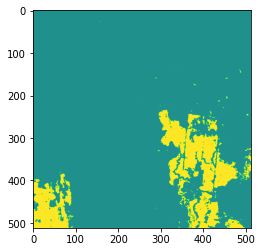

In [4]:
path = '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Mekong_342411_LabelHand.tif'

plt.imshow(tfl.imread(path))


## Validation Data Creation


total validation images: 89
total validation masks: 89
First 5 training images of validation data ['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_5079_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_895194_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_868803_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_142312_S1Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_234935_S1Hand.tif']
First 5 masks images of validation data ['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_5079_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_895194_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_868803_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_142312_LabelHand.tif', '/content/fl

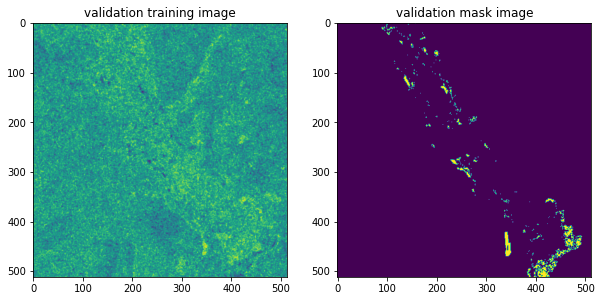

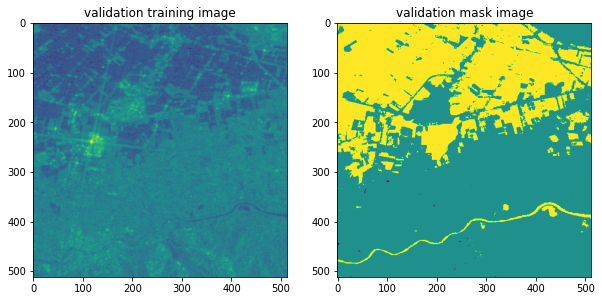

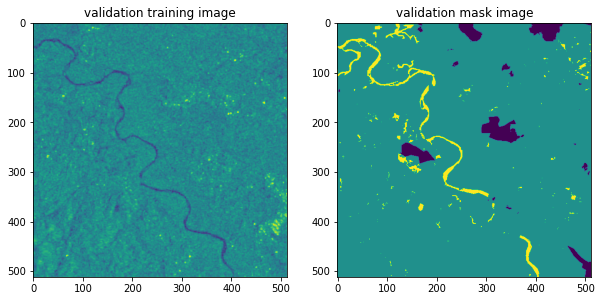

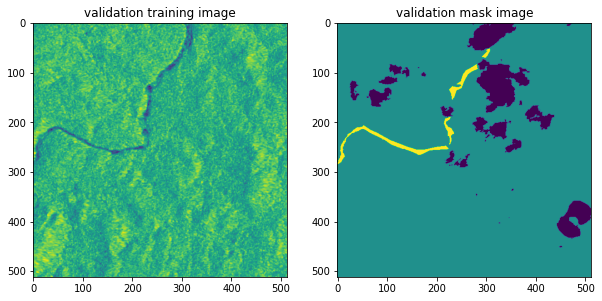

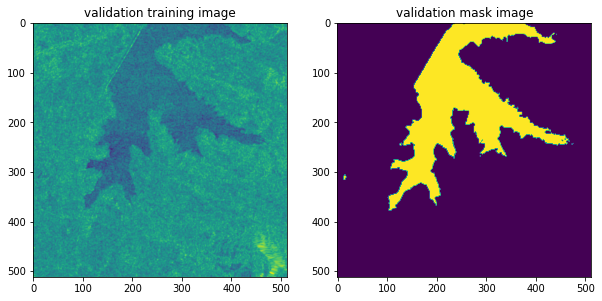

In [5]:
import pandas as pd
val_data = '/content/flood_valid_data.csv'
val_data = pd.read_csv(val_data)


val_image_list = val_data['Val Image'].tolist()
val_mask_list = val_data['Val Label'].tolist()

# make lists for validation image and validation mask directories

val_image_dir ='/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S1Hand' 
val_mask_dir = '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand'


val_image_paths=[]
for i in val_image_list:
  val_image_paths.append(str(val_image_dir+'/'+i))

val_mask_paths=[]
for i in val_mask_list:
  val_mask_paths.append(str(val_mask_dir+'/'+i))



print(f'total validation images: {len(val_image_paths)}')
print(f'total validation masks: {len(val_mask_paths)}')
print(f'First 5 training images of validation data {val_image_paths[:5]}')
print(f'First 5 masks images of validation data {val_mask_paths[:5]}')



#Test to check if images are the same
for i in range (5) :
  n = np.random.randint(len(val_image_paths))
  fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
  ax1.imshow(tfl.imread(val_image_paths[n])[0])
  ax1.set_title('validation training image')
  ax2.imshow(tfl.imread(val_mask_paths[n]))
  ax2.set_title('validation mask image')



# Training Data and testing data Creation 

total images: 446
total masks: 446
['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand/Ghana_154838_S2Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand/Spain_8154154_S2Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand/Sri-Lanka_31559_S2Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand/Paraguay_205585_S2Hand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand/Paraguay_1019808_S2Hand.tif']
['/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_154838_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Spain_8154154_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Sri-Lanka_31559_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Paraguay_205585_LabelHand.tif', '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand/Paraguay_1019808_LabelHa

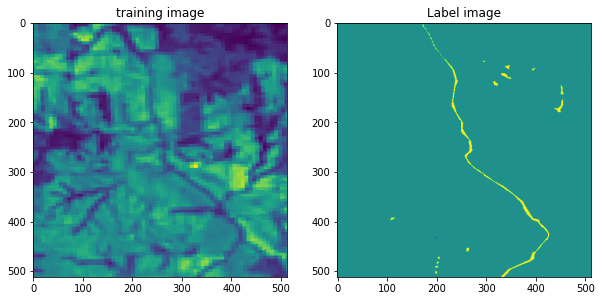

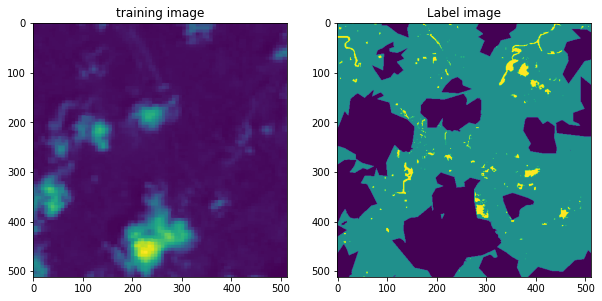

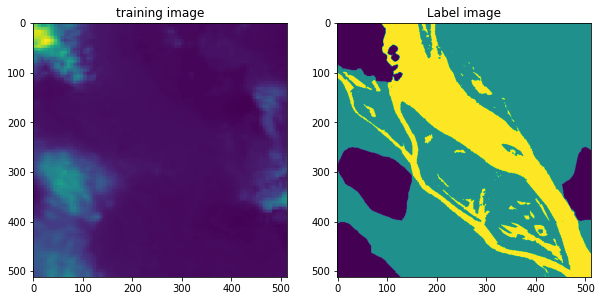

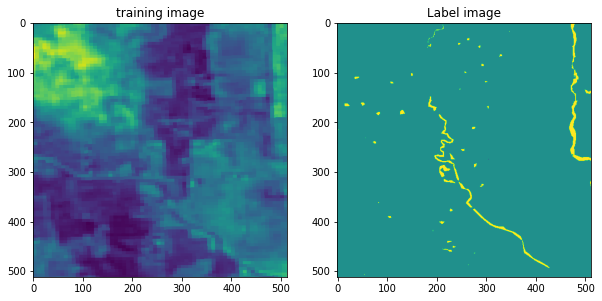

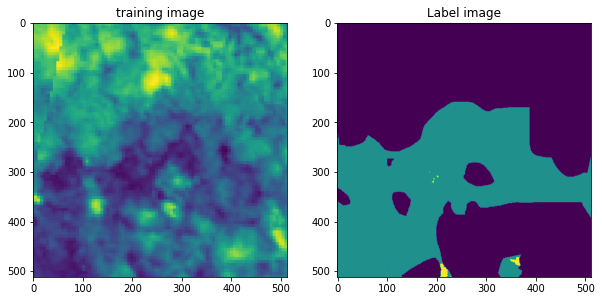

In [6]:
# make lists for image and mask directories
import glob
import random 

images_dir ='/content/floodsDataset/v1.1/data/flood_events/HandLabeled/S2Hand'    # Change your code here for model training for both Weak Labeled and Hand Labeled datasets training data
masks_dir = '/content/floodsDataset/v1.1/data/flood_events/HandLabeled/LabelHand' # Change your code here for model training for both Weak Labeled and Hand Labeled datasets label data

image_paths = sorted(glob.glob(f'{images_dir}/*'))
mask_paths = sorted(glob.glob(f'{masks_dir}/*'))


# number of validation samples
test_samples = round(len(image_paths)*0.3)
# test_samples = round()

random.Random(1337).shuffle(image_paths)
random.Random(1337).shuffle(mask_paths)

# Split our img paths into a training and a validation set
train_image_paths = image_paths[:-test_samples]
train_mask_paths = mask_paths[:-test_samples]

test_image_paths = image_paths[-test_samples:]
test_mask_paths = mask_paths[-test_samples:]




print(f'total images: {len(image_paths)}')
print(f'total masks: {len(mask_paths)}')
print(image_paths[:5])
print(mask_paths[:5])


print(f'total test images: {len(test_image_paths)}')
print(f'total test masks: {len(test_mask_paths)}')
print(test_image_paths[:5])
print(test_mask_paths[:5])



# #Test to check if images are the same
for i in range (5) :
  n = np.random.randint(len(train_image_paths))
  fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
  ax1.imshow(tfl.imread(train_image_paths[n])[0])
  ax1.set_title('training image')
  ax2.imshow(tfl.imread(train_mask_paths[n]))
  ax2.set_title('Label image')



In [7]:
from dataset import FloodDataset
from keras.callbacks import ModelCheckpoint

img_size = (512, 512)
batch_size = 16

train_gen = FloodDataset(batch_size,
                            img_size,
                            train_image_paths,
                            train_mask_paths)

test_gen = FloodDataset(batch_size,
                            img_size,
                            test_image_paths,
                            test_mask_paths)



val_gen = FloodDataset(batch_size,
                          img_size,
                          val_image_paths,
                          val_mask_paths)

x,y = train_gen[0]
print(f'Shape of training data {x.shape}, Shape of Label Data{y.shape}')

Shape of training data (16, 512, 512, 13), Shape of Label Data(16, 512, 512, 1)


In [8]:
print(len(train_gen),len(test_gen),len(val_gen))

19 8 5


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from loss import bce_dice_loss, dice_coef
from metrics import recall_m,precision_m,f1_m

activation_function = 'sigmoid'
num_classes = 1

from models import UNet
model = UNet(num_classes = num_classes,
         image_size = 512, 
         img_channels = 13,
         activation_fn = 'sigmoid')

# from models import DeepUNet
# model =  DeepUNet(num_classes=num_classes,
#              image_size=512,
#              img_channels=2,
#              activation_fn = 'sigmoid',
#              )
#// Cannot test DeepNet Model yet : Error (ResourceExhaustedError: Graph execution error:)

loss = bce_dice_loss # can use 'binary_crossentropy'
optimizer = Adam()

# compile model
model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = [recall_m, 
                        precision_m, 
                        f1_m])

(16, 512, 512, 1) (16, 512, 512, 1)


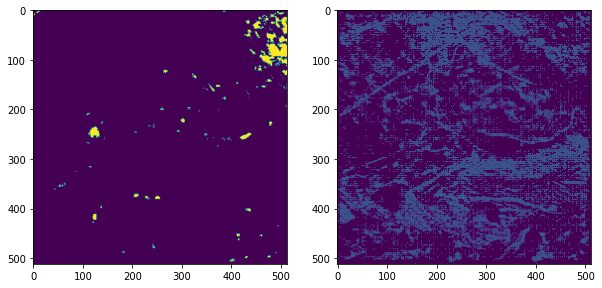

In [12]:
# Tesing with sample model to check input shape and output shape
x,y = train_gen[0]
x.shape,y.shape

test = model.predict(x)
print(test.shape,y.shape)

fig,(ax1,ax2) = plt.subplots(1,2 ,figsize=(10,10))
ax1.imshow(np.squeeze(y)[1])
ax2.imshow(np.squeeze(test)[1])


In [13]:
# Train the model, doing validation at the end of each epoch.
epochs = 100

checkpoint = ModelCheckpoint("/content/Train_S1_hand_Label_S2.hdf5", monitor='f1_m', verbose=1,
    save_best_only=True, mode='auto', period=1) 

history = model.fit(train_gen, 
          epochs=epochs, 
          validation_data=test_gen,
          verbose = 1)

Epoch 1/100
19/19 [==============================] - 340s 18s/step - loss: 43.2941 - recall_m: 0.1425 - precision_m: 0.1985 - f1_m: 0.1427 - val_loss: 3.2610 - val_recall_m: 0.3797 - val_precision_m: 0.6312 - val_f1_m: 0.4521
Epoch 2/100
19/19 [==============================] - 172s 9s/step - loss: 5.2508 - recall_m: 0.4367 - precision_m: 0.4416 - f1_m: 0.4322 - val_loss: 1.5047 - val_recall_m: 0.6532 - val_precision_m: 0.6618 - val_f1_m: 0.6480
Epoch 3/100
19/19 [==============================] - 170s 9s/step - loss: 2.5906 - recall_m: 0.5615 - precision_m: 0.5994 - f1_m: 0.5764 - val_loss: 1.0231 - val_recall_m: 0.7443 - val_precision_m: 0.7989 - val_f1_m: 0.7679
Epoch 4/100
19/19 [==============================] - 171s 9s/step - loss: 1.7027 - recall_m: 0.6149 - precision_m: 0.6668 - f1_m: 0.6355 - val_loss: 0.6939 - val_recall_m: 0.8084 - val_precision_m: 0.7307 - val_f1_m: 0.7653
Epoch 5/100
19/19 [==============================] - 172s 9s/step - loss: 1.2301 - recall_m: 0.6168 - 

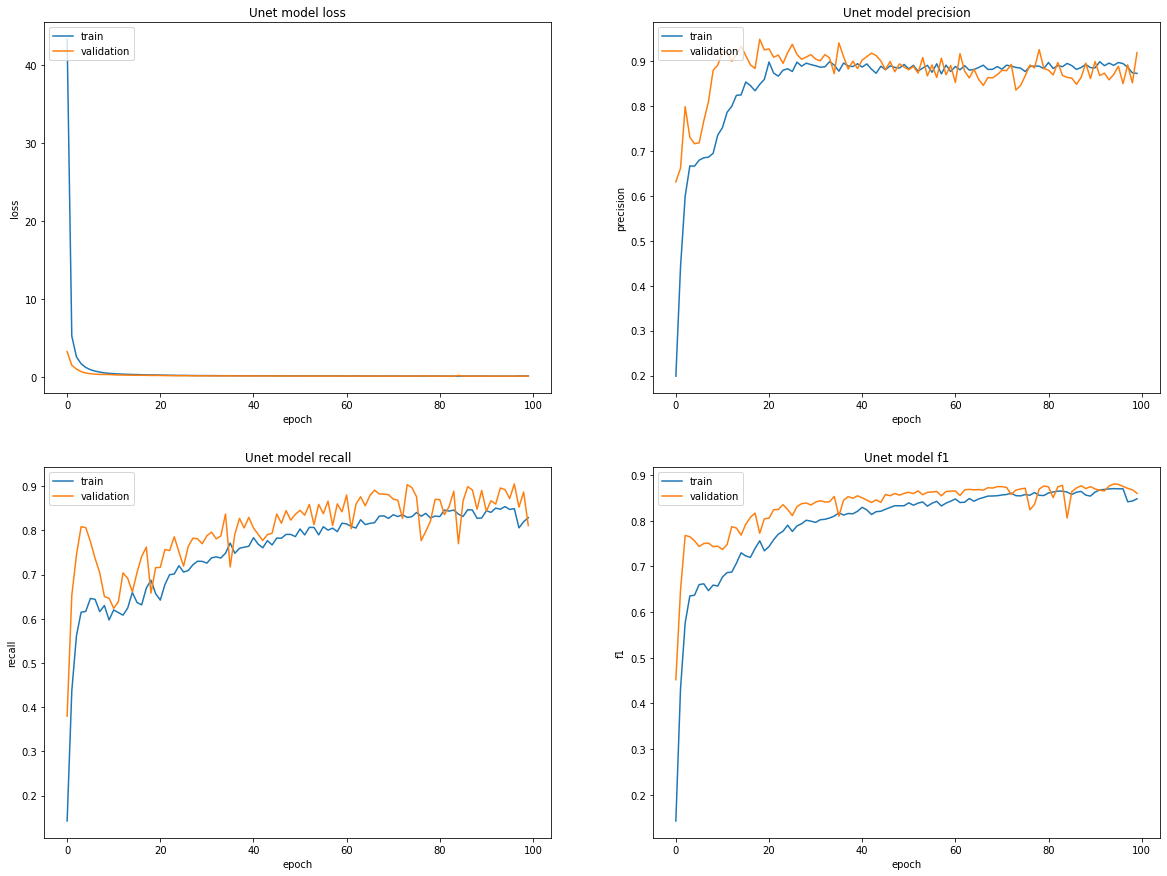

In [15]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')
fig.savefig('3_Train_S1 Hand_Label_S2_Label_Hand.png')

In [16]:
# Validation data

loss1,recall,precision,f1 = model.evaluate(test_gen,verbose=1)
print(f"Validation Metrics on Unet \nprecision :{precision*100} \nf1 score :{f1*100} \nrecall :{recall*100} \nLoss :{loss1}")

8/8 [==============================] - 47s 6s/step - loss: 0.1205 - recall_m: 0.8113 - precision_m: 0.9193 - f1_m: 0.8603
Validation Metrics on Unet 
precision :91.93193316459656 
f1 score :86.02836728096008 
recall :81.13154172897339 
Loss :0.12053032219409943


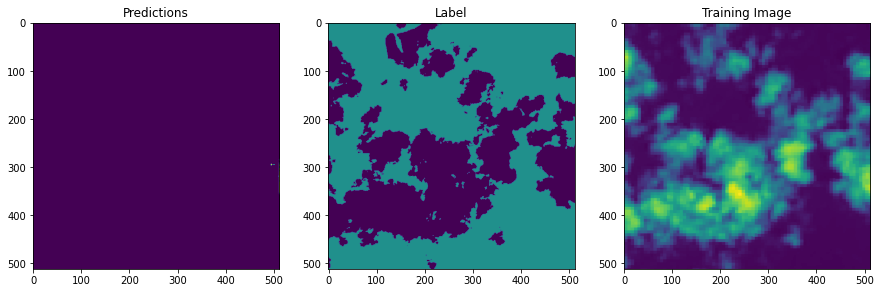

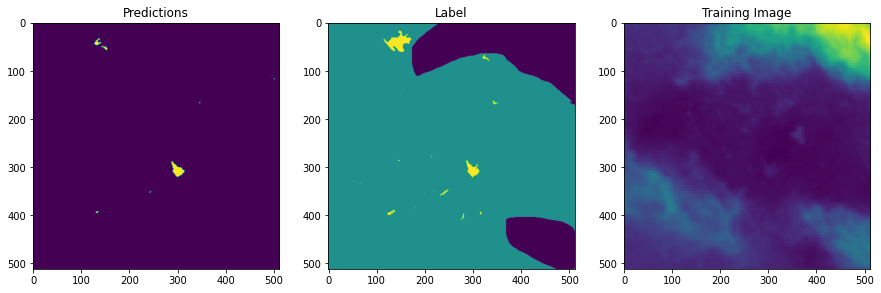

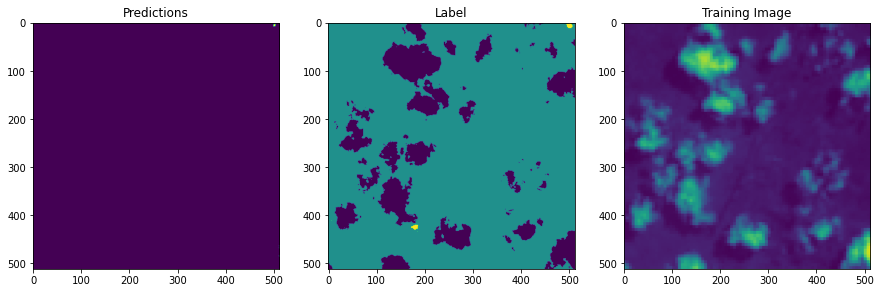

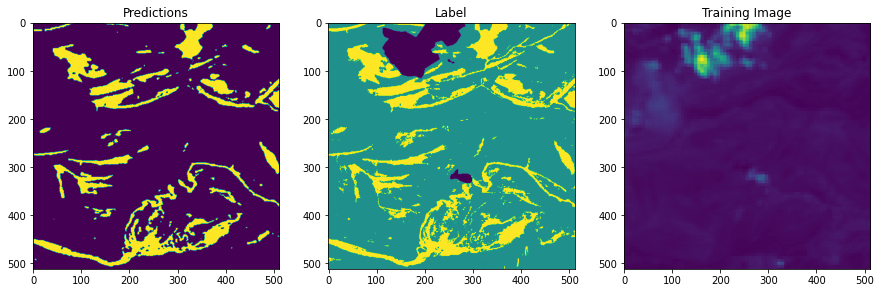

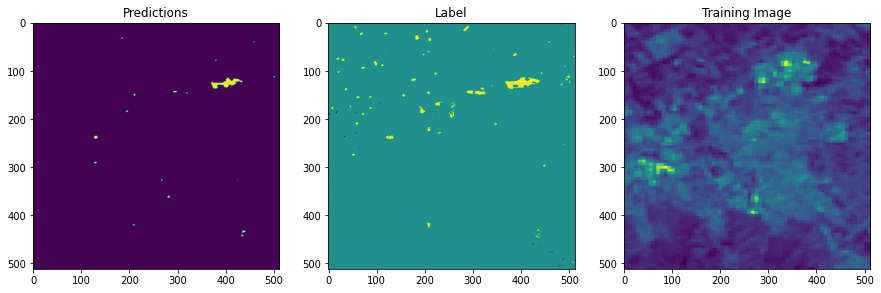

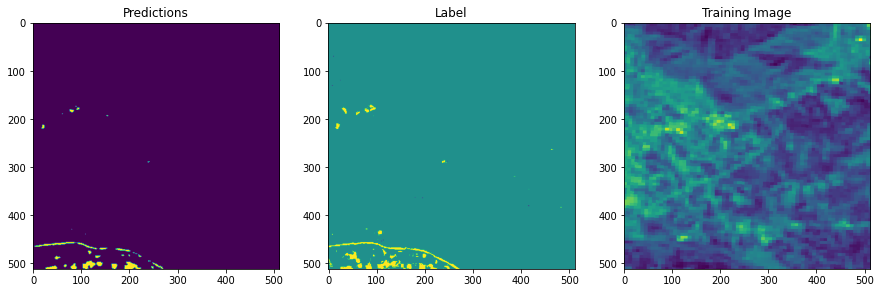

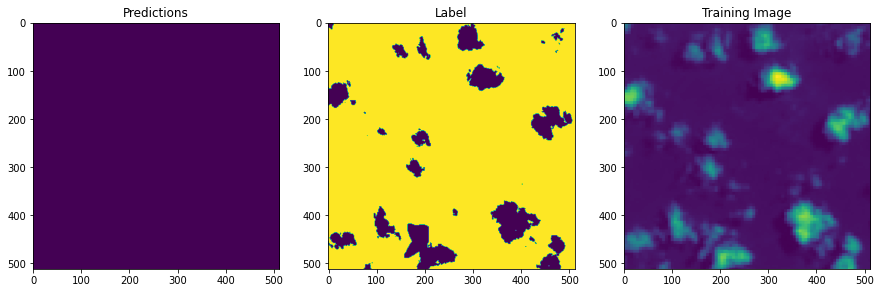

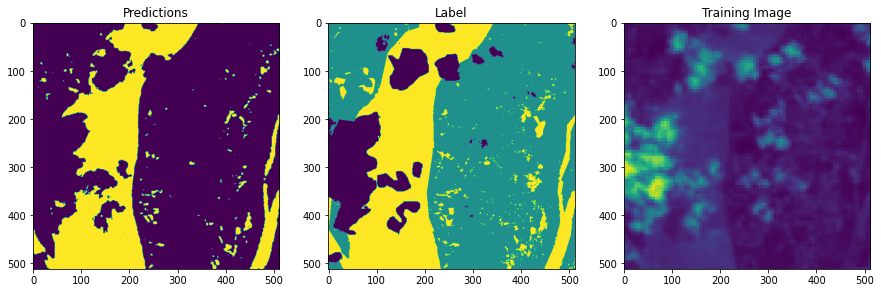

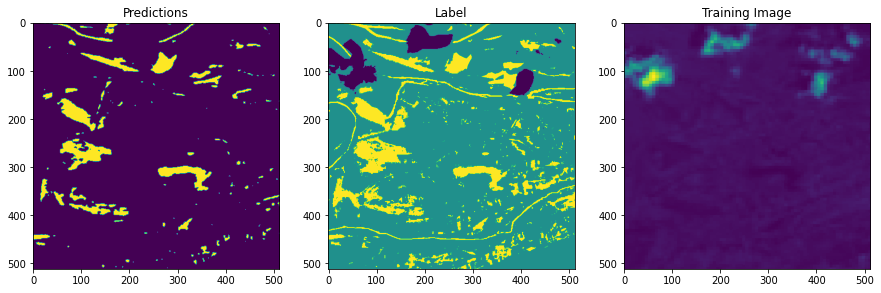

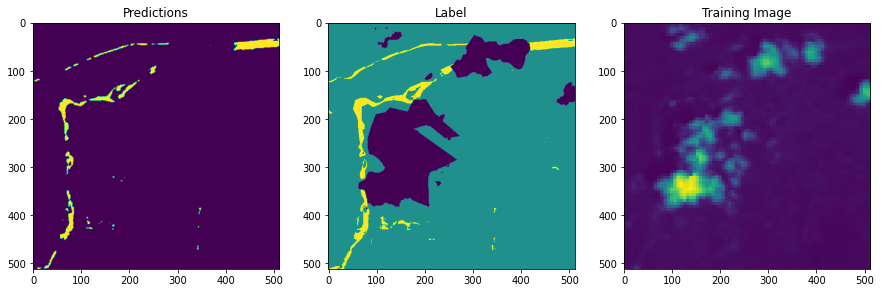

In [17]:
for i in range( 10):
  n = np.random.randint(len(test_image_paths))

  # print(f"Inferecne Image Path {image_paths[n]}")
  # print(f"Inference Mask Path {mask_paths[n]}")
  infer_image = test_image_paths[n]
  infer_label = test_mask_paths[n]

  sample = np.moveaxis(tfl.imread(infer_image),0,2)
  threshold = 0.9
  pred_img = np.expand_dims(sample, axis = 0)
  val_preds = model.predict(pred_img)
  val_preds = np.squeeze(val_preds)
  val_preds = val_preds > threshold

  fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
  ax1.imshow(val_preds);
  ax1.set_title("Predictions")
  ax2.imshow(tfl.imread(infer_label));
  ax2.set_title("Label")
  ax3.imshow(tfl.imread(infer_image)[0]);
  ax3.set_title('Training Image')

  fig.savefig('Preds/Preds_'+str(i)+'.png')


In [18]:
 !zip -r '/content/Preds_4_Train_S1 Hand_Label_S2_Hand.zip' '/content/Preds'

  adding: content/Preds/ (stored 0%)
  adding: content/Preds/Preds_9.png (deflated 6%)
  adding: content/Preds/Preds_0.png (deflated 4%)
  adding: content/Preds/Preds_7.png (deflated 3%)
  adding: content/Preds/Preds_4.png (deflated 6%)
  adding: content/Preds/Preds_1.png (deflated 8%)
  adding: content/Preds/Preds_8.png (deflated 3%)
  adding: content/Preds/Preds_3.png (deflated 3%)
  adding: content/Preds/Preds_5.png (deflated 6%)
  adding: content/Preds/Preds_6.png (deflated 7%)
  adding: content/Preds/Preds_2.png (deflated 5%)


In [19]:
model.save('/content/4_Train_S1 Hand_Label_S2.h5')